# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.91MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# The model
Let's start with the model we first saw

In [10]:
import torch.nn.functional as F
dropout_value = 0.025
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # 28x28x1 => 26x26x8

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # 26x26x8 => 24x24x16

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # 24x24x10
        self.pool1 = nn.MaxPool2d(2, 2) # 24x24x10 => 12x12x10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # 12x12x10 => 10x10x10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) #10x10x10 => 10x10x16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # 10x10x16 =>8x8x16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # 8x8x16 => 6x6x10
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # 6x6x10 => 6x6x10

        self.pool2 = nn.MaxPool2d(2, 2) # 6x6x10 => 3x3x10


        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1)
        ) # output_size = 1

        self.fc = nn.Linear(10 ,10 )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.pool2(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1) # Explicitly flatten to (batch_size, number_of_features)
        x = self.fc(x)


        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print("Please ensure you have run the cell with the updated Net class definition before running this cell.")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
Please ensure you have run the cell with the updated Net class definition before running this cell.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 15
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.75,  # Peak LR (0.75)
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # 30% warmup
    anneal_strategy='cos',
    div_factor=7.5,  # Initial LR = 0.75 / 7.5 = 0.1
    final_div_factor=7.5,  # Final LR = 0.75 / 7.5 = 0.1
    cycle_momentum=False  # Disable momentum cycling for Adagrad
)


EPOCHS = num_epochs
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loss=0.029253924265503883 Batch_id=468 Accuracy=92.19: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]



Test set: Average loss: 0.0522, Accuracy: 9838/10000 (98.38%)

EPOCH: 1


Loss=0.08322650194168091 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]



Test set: Average loss: 0.0431, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.027021558955311775 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:19<00:00, 23.96it/s]



Test set: Average loss: 0.0365, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.03232695534825325 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]



Test set: Average loss: 0.0325, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.09542378038167953 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:19<00:00, 24.07it/s]



Test set: Average loss: 0.0258, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.02943205088376999 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:19<00:00, 24.16it/s]



Test set: Average loss: 0.0280, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.00824173353612423 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]



Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.007212548051029444 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:19<00:00, 24.24it/s]



Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.012324732728302479 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:19<00:00, 24.25it/s]



Test set: Average loss: 0.0277, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.006829916033893824 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]



Test set: Average loss: 0.0250, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.019599338993430138 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]



Test set: Average loss: 0.0274, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.04851944372057915 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]



Test set: Average loss: 0.0222, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.0057678851298987865 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]



Test set: Average loss: 0.0284, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Loss=0.06713732331991196 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]



Test set: Average loss: 0.0224, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.0049122697673738 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:19<00:00, 24.40it/s]



Test set: Average loss: 0.0253, Accuracy: 9936/10000 (99.36%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

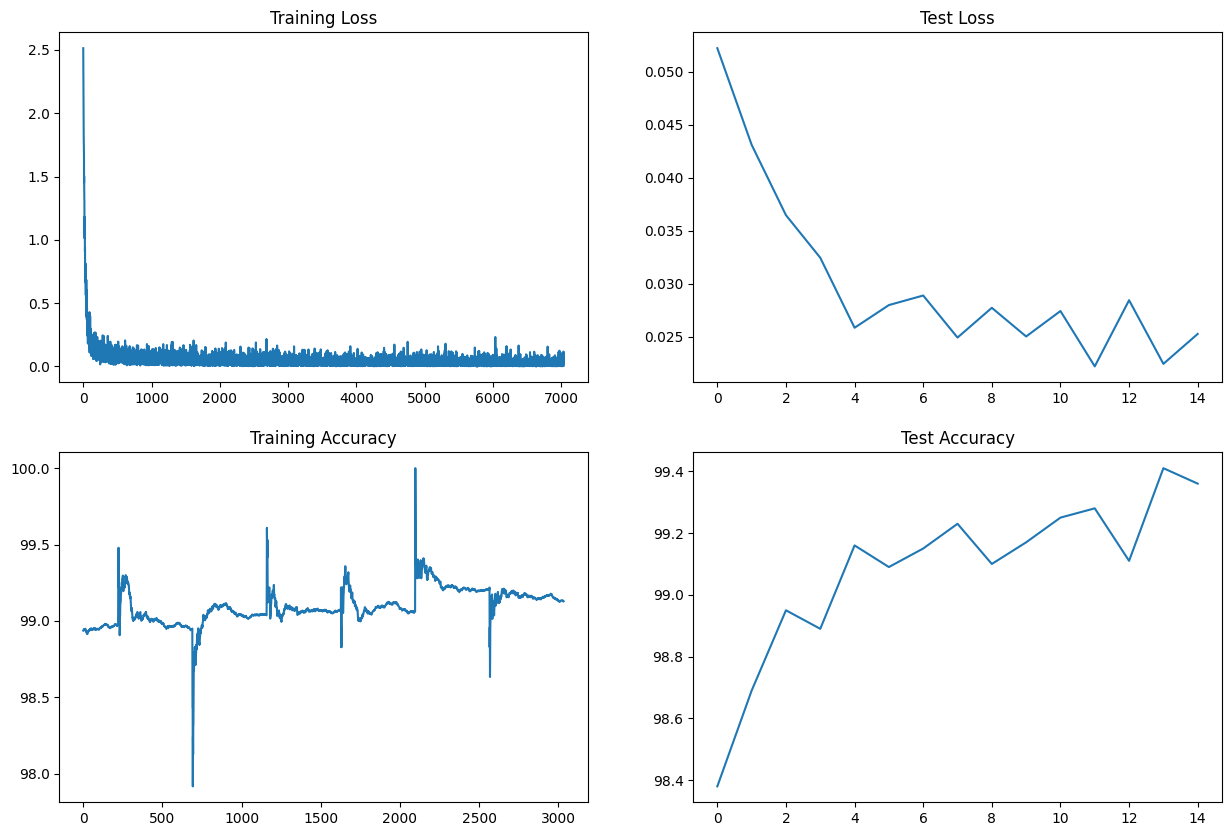

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")